In [77]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from pathlib import Path
from collections import Counter

from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [78]:
# Load the data
file_path = "c:./Resources/joined_loans_v5_clean.csv"
df = pd.read_csv(file_path)
df.head()

,keyid,loantype,loanbranch,acctnumber,loanid,loandescription,loanpurposecode,loanpurposecodedesc,loanopendate,loanapprovalcode,...,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loandelqdays,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,327320,0,PERSONAL LOAN,25,Personal/Miscellaneous,6/26/2019,1407,...,14.50,1000.00,91.87,12,128,0,0.3630,0.0,4,1.0
1,3256971,5,21,325697,1,2015 DODGE CHARGER,172,Mini of Hawaii,6/22/2019,1437,...,16.25,23399.52,645.81,60,135,530,0.0000,0.0,5,1.0
2,3054723,9,11,305472,3,PERSONAL LOAN,3,Consolidation,6/19/2019,780,...,7.00,18855.64,373.53,60,133,722,0.4139,0.0,1,1.0
3,3111884,9,8,311188,4,DOWNPAYMENT,3,Consolidation,6/17/2019,570,...,15.50,1570.00,145.22,12,133,571,0.3862,0.0,5,1.0
4,3122810,9,1,312281,0,PERSONAL LOAN,3,Consolidation,5/29/2019,780,...,6.00,14536.00,308.23,60,123,720,0.7634,0.0,1,1.0


In [79]:
df.dtypes

keyid                        int64
loantype                     int64
loanbranch                   int64
acctnumber                   int64
loanid                       int64
loandescription             object
loanpurposecode              int64
loanpurposecodedesc         object
loanopendate                object
loanapprovalcode             int64
loanapprovalofficername     object
loaninterestrate           float64
loanoriginalbalance        float64
loanpayment                float64
loanpaymentcount             int64
loandelqdays                 int64
loancreditscore              int64
debtratio                  float64
loantovalue                float64
rbl                          int64
loanchargeoffdate          float64
dtype: object

In [80]:
# Find null values
for column in df.columns:
    print(f'Column {column} has {df[column].isnull().sum()} null values')

Column keyid has 0 null values
Column loantype has 0 null values
Column loanbranch has 0 null values
Column acctnumber has 0 null values
Column loanid has 0 null values
Column loandescription has 0 null values
Column loanpurposecode has 0 null values
Column loanpurposecodedesc has 29 null values
Column loanopendate has 0 null values
Column loanapprovalcode has 0 null values
Column loanapprovalofficername has 28 null values
Column loaninterestrate has 0 null values
Column loanoriginalbalance has 0 null values
Column loanpayment has 0 null values
Column loanpaymentcount has 0 null values
Column loandelqdays has 0 null values
Column loancreditscore has 0 null values
Column debtratio has 0 null values
Column loantovalue has 0 null values
Column rbl has 0 null values
Column loanchargeoffdate has 21333 null values


In [81]:
# Create a new DataFrame that removes unwanted features.

loans_df = df.drop(columns=["acctnumber", 
                            "loanid",
                            "loandescription",
                            "loanpurposecodedesc",
                            "loanopendate",
                            "loanapprovalofficername",
                            "loandelqdays"
                           ])
loans_df

,keyid,loantype,loanbranch,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,25,1407,14.50,1000.00,91.87,12,0,0.3630,0.0000,4,1.0
1,3256971,5,21,172,1437,16.25,23399.52,645.81,60,530,0.0000,0.0000,5,1.0
2,3054723,9,11,3,780,7.00,18855.64,373.53,60,722,0.4139,0.0000,1,1.0
3,3111884,9,8,3,570,15.50,1570.00,145.22,12,571,0.3862,0.0000,5,1.0
4,3122810,9,1,3,780,6.00,14536.00,308.23,60,720,0.7634,0.0000,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,2859041,9,7,90,585,5.50,40180.00,592.87,84,843,0.3294,0.0000,1,NaN
22504,259490,9,1,7,780,4.50,20000.00,373.02,60,772,0.3633,0.0000,1,NaN
22505,1165586,5,7,13,780,3.25,18239.00,362.72,60,734,0.3455,1.0287,1,NaN
22506,1736283,12,4,40,570,6.75,25000.00,259.00,0,791,0.3218,0.0000,1,NaN


In [82]:
# Convert loanchargeoffdate non-Charge-off loans to 0
loans_df['loanchargeoffdate'] = loans_df['loanchargeoffdate'].replace([np.nan], 0)
loans_df

,keyid,loantype,loanbranch,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,25,1407,14.50,1000.00,91.87,12,0,0.3630,0.0000,4,1.0
1,3256971,5,21,172,1437,16.25,23399.52,645.81,60,530,0.0000,0.0000,5,1.0
2,3054723,9,11,3,780,7.00,18855.64,373.53,60,722,0.4139,0.0000,1,1.0
3,3111884,9,8,3,570,15.50,1570.00,145.22,12,571,0.3862,0.0000,5,1.0
4,3122810,9,1,3,780,6.00,14536.00,308.23,60,720,0.7634,0.0000,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,2859041,9,7,90,585,5.50,40180.00,592.87,84,843,0.3294,0.0000,1,0.0
22504,259490,9,1,7,780,4.50,20000.00,373.02,60,772,0.3633,0.0000,1,0.0
22505,1165586,5,7,13,780,3.25,18239.00,362.72,60,734,0.3455,1.0287,1,0.0
22506,1736283,12,4,40,570,6.75,25000.00,259.00,0,791,0.3218,0.0000,1,0.0


In [83]:
# Delete rows where debtratio = 0.  debtratio believed to be significant to prediction.
# Unfortunately will lose numerous auto dealership loans from dataset.
loans_df = loans_df[loans_df.debtratio != 0]
loans_df

,keyid,loantype,loanbranch,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,25,1407,14.50,1000.00,91.87,12,0,0.3630,0.0000,4,1.0
2,3054723,9,11,3,780,7.00,18855.64,373.53,60,722,0.4139,0.0000,1,1.0
3,3111884,9,8,3,570,15.50,1570.00,145.22,12,571,0.3862,0.0000,5,1.0
4,3122810,9,1,3,780,6.00,14536.00,308.23,60,720,0.7634,0.0000,1,1.0
5,336724,9,5,3,166,8.25,18048.20,369.26,60,691,0.4380,0.0000,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,2859041,9,7,90,585,5.50,40180.00,592.87,84,843,0.3294,0.0000,1,0.0
22504,259490,9,1,7,780,4.50,20000.00,373.02,60,772,0.3633,0.0000,1,0.0
22505,1165586,5,7,13,780,3.25,18239.00,362.72,60,734,0.3455,1.0287,1,0.0
22506,1736283,12,4,40,570,6.75,25000.00,259.00,0,791,0.3218,0.0000,1,0.0


In [84]:
loans_df["loanchargeoffdate"].value_counts()

0.0    15912
1.0      731
Name: loanchargeoffdate, dtype: int64

In [85]:
loans_df["loantype"].value_counts()

9     11192
5      2159
12     2136
1       673
11      483
Name: loantype, dtype: int64

In [86]:
loantype_df = pd.DataFrame(loans_df["loantype"].value_counts()).reset_index()
loantype_df

,index,loantype
0,9,11192
1,5,2159
2,12,2136
3,1,673
4,11,483


In [87]:
import plotly.express as px

fig = px.bar(loantype_df, x='index', y='loantype')
fig.show()

# Bin loanpurposecode and loanapprovalcode

In [88]:
# Loan Purpose Code
loanpurposecode_cts = loans_df["loanpurposecode"].value_counts()
loanpurposecode_cts

3      5081
25     3699
40     2130
13     1540
2      1012
       ... 
94        1
174       1
915       1
162       1
161       1
Name: loanpurposecode, Length: 81, dtype: int64

<AxesSubplot:ylabel='Density'>

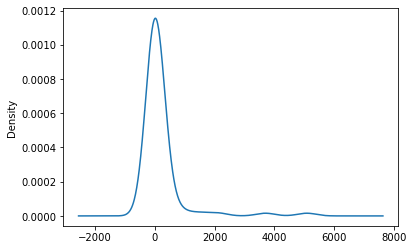

In [89]:
# Visualize the value counts of loanapprovalcode
loanpurposecode_cts.plot.density()

In [90]:
# Bin loans_df.loanpurposecode_cts < 100  (reduced from 275 in version 5.1)
replace_loanpurposecode = list(loanpurposecode_cts[loanpurposecode_cts < 100].index)
# replace_loanpurposecode

# Replace in dataframe
for loan in replace_loanpurposecode:
    loans_df.loanpurposecode = loans_df.loanpurposecode.replace(loan,9999)
    
# Verify binning was successful
loans_df.loanpurposecode.value_counts()

3       5081
25      3699
40      2130
13      1540
2       1012
9999     800
23       681
43       470
14       413
17       321
24       191
8        182
7        123
Name: loanpurposecode, dtype: int64

In [91]:
# Loan Approval Code
loanapprovalcode_cts = loans_df["loanapprovalcode"].value_counts()
loanapprovalcode_cts

780     5253
1437    3090
585     1801
570     1214
47       993
1017     769
55       747
1407     703
1916     687
166      346
1176     336
1090     270
1462     179
341      113
241       90
61        22
426       12
1841       4
1795       3
201        2
284        1
20         1
1098       1
1770       1
775        1
84         1
1044       1
24         1
0          1
Name: loanapprovalcode, dtype: int64

<AxesSubplot:ylabel='Density'>

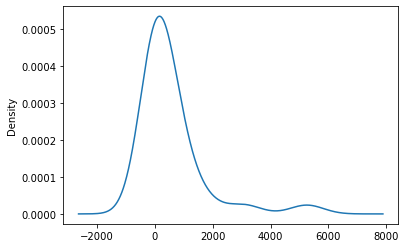

In [92]:
# Visualize the value counts of loanapprovalcode
loanapprovalcode_cts.plot.density()

In [93]:
# Bin loans_df.loanapprovalcode < 100 (Version 7.0 C)
replace_loanapprovalcode = list(loanapprovalcode_cts[loanapprovalcode_cts < 100].index)

# Replace in dataframe
for loan in replace_loanapprovalcode:
    loans_df.loanapprovalcode = loans_df.loanapprovalcode.replace(loan,9999)
    
# Verify binning was successful
loans_df.loanapprovalcode.value_counts()

780     5253
1437    3090
585     1801
570     1214
47       993
1017     769
55       747
1407     703
1916     687
166      346
1176     336
1090     270
1462     179
9999     142
341      113
Name: loanapprovalcode, dtype: int64

In [94]:
loans_df.dtypes

keyid                    int64
loantype                 int64
loanbranch               int64
loanpurposecode          int64
loanapprovalcode         int64
loaninterestrate       float64
loanoriginalbalance    float64
loanpayment            float64
loanpaymentcount         int64
loancreditscore          int64
debtratio              float64
loantovalue            float64
rbl                      int64
loanchargeoffdate      float64
dtype: object

# Best Random Forest Model Model - Version 7.1 C

## Split the Data into Training and Testing

In [95]:
# Version N - eliminate "noisy" features

X = loans_df[[
#             'loantype',
#              'loanbranch',
             'loanpurposecode',
             'loanapprovalcode',
             'loaninterestrate',
             'loanoriginalbalance',
             'loanpayment',
             'loanpaymentcount',
             'loancreditscore',
             'debtratio',
#              'loantovalue'
             'rbl'
             ]]
y = loans_df["loanchargeoffdate"]

In [96]:
X

,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,rbl
0,25,1407,14.50,1000.00,91.87,12,0,0.3630,4
2,3,780,7.00,18855.64,373.53,60,722,0.4139,1
3,3,570,15.50,1570.00,145.22,12,571,0.3862,5
4,3,780,6.00,14536.00,308.23,60,720,0.7634,1
5,3,166,8.25,18048.20,369.26,60,691,0.4380,2
...,...,...,...,...,...,...,...,...,...
22503,9999,585,5.50,40180.00,592.87,84,843,0.3294,1
22504,7,780,4.50,20000.00,373.02,60,772,0.3633,1
22505,13,780,3.25,18239.00,362.72,60,734,0.3455,1
22506,40,570,6.75,25000.00,259.00,0,791,0.3218,1


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [98]:
X_train

,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,rbl
10699,3,585,10.25,25752.98,600.74,60,648,0.2685,3
3527,3,1437,10.25,15000.00,516.74,36,678,0.3260,3
13692,40,780,6.75,14981.61,459.00,0,684,0.1192,2
1021,25,1437,10.25,20000.00,530.11,48,649,0.4374,3
21056,40,1090,6.75,5000.00,134.00,0,692,0.2201,1
...,...,...,...,...,...,...,...,...,...
10237,23,1437,9.25,2500.00,119.30,24,657,0.3269,3
14631,3,780,5.75,22000.00,455.99,60,751,0.3757,1
6567,24,780,6.25,10000.00,213.23,60,780,0.4621,1
16223,7,780,5.75,15000.00,316.52,60,726,0.8662,1


## Scaler

In [99]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.23236987, -0.38358773,  0.7757811 , ..., -0.23986337,
        -0.3508537 ,  0.89263991],
       [-0.23236987,  0.50212877,  0.7757811 , ..., -0.0630828 ,
        -0.13079067,  0.89263991],
       [-0.21511879, -0.18087093, -0.26592454, ..., -0.02772669,
        -0.92225216,  0.03726293],
       ...,
       [-0.22257872, -0.18087093, -0.41473964, ...,  0.53797111,
         0.39008897, -0.81811405],
       [-0.23050489, -0.18087093, -0.56355473, ...,  0.2197661 ,
         1.93665371, -0.81811405],
       [-0.23283612, -0.93456161, -0.191517  , ..., -0.01594132,
        -0.85565917,  0.03726293]])

In [100]:
# # export X_train to csv
X_train_scaled_df = pd.DataFrame(X_train)
X_train_scaled_df 
X_train_scaled_df.to_csv(r"c:./csv_exports/X_train_scaled_df.csv", header = True)

##  Balanced Random Forest Classifier - SCALED

In [101]:
# Resample the training data with the BalancedRandomForestClassifier

# Create a random forest classifier.
loan_model = BalancedRandomForestClassifier(n_estimators=128, random_state=1) 

# Fitting the model
loan_model = loan_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data.
predictions = loan_model.predict(X_test_scaled)
predictions

array([1., 0., 0., ..., 0., 0., 0.])

In [102]:
print(f'Training Score: {loan_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {loan_model.score(X_test_scaled, y_test)}')

Training Score: 0.6384257172900706
Testing Score: 0.600180234304596


In [103]:
print(f'Training Score: {loan_model.score(X_train, y_train)}')
print(f'Testing Score: {loan_model.score(X_test, y_test)}')

Training Score: 0.7908968003605228
Testing Score: 0.78642234905377


In [104]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

0.6583917718560075

In [105]:
# Display the confusion matrix
# -----------------
# true good  | false CO
# false good | true CO

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual Good", "Actual C/O"], columns=["Predicted Good", "Predicted C/O"])
cm_df

,Predicted Good,Predicted C/O
Actual Good,1886,1288
Actual C/O,43,112


In [106]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.59      0.72      0.74      0.66      0.42      3174
        1.0       0.08      0.72      0.59      0.14      0.66      0.43       155

avg / total       0.94      0.60      0.72      0.71      0.66      0.42      3329



In [107]:
# List the features sorted in descending order by feature importance
sorted(zip(loan_model.feature_importances_, X.columns), reverse=True)

[(0.205609041345152, 'loancreditscore'),
 (0.16844423240227266, 'debtratio'),
 (0.15466460751562794, 'loanpayment'),
 (0.12538614918682423, 'loaninterestrate'),
 (0.12414344386440652, 'loanoriginalbalance'),
 (0.08091320116475324, 'loanapprovalcode'),
 (0.05484270030595342, 'loanpurposecode'),
 (0.04558813383181336, 'loanpaymentcount'),
 (0.04040849038319673, 'rbl')]

In [108]:
# export feature_importances to rank_features csv
rank_features = sorted(zip(loan_model.feature_importances_, X.columns), reverse=True)
rank_features_df = pd.DataFrame(rank_features)
rank_features_df 
rank_features_df.to_csv(r"c:./csv_exports/rank_features_df_7.1C.csv", header = True)

## User Input Version

# Balanced Random Forest Classifier - NOT SCALED
#### Not scaled to simplify user input

In [109]:
# Load the data
file_path = "c:./Resources/joined_loans_v5_clean.csv"
df = pd.read_csv(file_path)
df.head()

,keyid,loantype,loanbranch,acctnumber,loanid,loandescription,loanpurposecode,loanpurposecodedesc,loanopendate,loanapprovalcode,...,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loandelqdays,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,327320,0,PERSONAL LOAN,25,Personal/Miscellaneous,6/26/2019,1407,...,14.50,1000.00,91.87,12,128,0,0.3630,0.0,4,1.0
1,3256971,5,21,325697,1,2015 DODGE CHARGER,172,Mini of Hawaii,6/22/2019,1437,...,16.25,23399.52,645.81,60,135,530,0.0000,0.0,5,1.0
2,3054723,9,11,305472,3,PERSONAL LOAN,3,Consolidation,6/19/2019,780,...,7.00,18855.64,373.53,60,133,722,0.4139,0.0,1,1.0
3,3111884,9,8,311188,4,DOWNPAYMENT,3,Consolidation,6/17/2019,570,...,15.50,1570.00,145.22,12,133,571,0.3862,0.0,5,1.0
4,3122810,9,1,312281,0,PERSONAL LOAN,3,Consolidation,5/29/2019,780,...,6.00,14536.00,308.23,60,123,720,0.7634,0.0,1,1.0


In [110]:
loans_df = df.drop(columns=["acctnumber", 
                            "loanid",
                            "loandescription",
                            "loanpurposecodedesc",
                            "loanopendate",
                            "loanapprovalofficername",
                            "loandelqdays"
                           ])


In [111]:
loans_df['loanchargeoffdate'] = loans_df['loanchargeoffdate'].replace([np.nan], 0)

In [112]:
loans_df = loans_df[loans_df.debtratio != 0]

### Number of features reduced to simply user input

In [132]:
X = loans_df[[
#             'loantype',
#              'loanbranch',
#              'loanpurposecode',
#              'loanapprovalcode',
             'loaninterestrate',
             'loanoriginalbalance',
#              'loanpayment',
#              'loanpaymentcount',
#              'loancreditscore',
             'debtratio',
             'loantovalue',
             'rbl'
             ]]
y = loans_df["loanchargeoffdate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)


In [133]:
loan_model = BalancedRandomForestClassifier(n_estimators=500, random_state=1) 

# Fitting the model
loan_model = loan_model.fit(X_train, y_train)

# Making predictions using the testing data.
predictions = loan_model.predict(X_test)


In [134]:
print(f'Training Score: {loan_model.score(X_train, y_train)}')
print(f'Testing Score: {loan_model.score(X_test, y_test)}')

Training Score: 0.6378999549346552
Testing Score: 0.607089215980775


In [135]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

0.6313321950525439

In [136]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual Good", "Actual C/O"], columns=["Predicted Good", "Predicted C/O"])
cm_df

,Predicted Good,Predicted C/O
Actual Good,1919,1255
Actual C/O,53,102


In [118]:
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.60      0.66      0.75      0.63      0.40      3174
        1.0       0.08      0.66      0.60      0.13      0.63      0.40       155

avg / total       0.93      0.61      0.66      0.72      0.63      0.40      3329



# ************************************

In [138]:
# USER INTERACTION

r=int(input("Enter Interest Rate: "))
amt=int(input("Enter Loan Amount: "))
tm=int(input("Enter Loan Term in Months: "))
dr=float(input("Enter Debt Ratio (0-1): "))
rbl=int(input("Enter Tier (1-5): "))

pr = loan_model.predict([[r, amt, tm, dr, rbl]])

if pr == 0:
    print("Result:  Good Loan")
else:
    print("Result: Bad Loan")

Enter Interest Rate: 15
Enter Loan Amount: 25000
Enter Loan Term in Months: 60
Enter Debt Ratio (0-1): .5
Enter Tier (1-5): 5
Result: Bad Loan


# ************************************

## Easy Ensemble AdaBoost Classifier

In [120]:
# Load the data
file_path = "c:./Resources/joined_loans_v5_clean.csv"
df = pd.read_csv(file_path)
df.head()

,keyid,loantype,loanbranch,acctnumber,loanid,loandescription,loanpurposecode,loanpurposecodedesc,loanopendate,loanapprovalcode,...,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loandelqdays,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,327320,0,PERSONAL LOAN,25,Personal/Miscellaneous,6/26/2019,1407,...,14.50,1000.00,91.87,12,128,0,0.3630,0.0,4,1.0
1,3256971,5,21,325697,1,2015 DODGE CHARGER,172,Mini of Hawaii,6/22/2019,1437,...,16.25,23399.52,645.81,60,135,530,0.0000,0.0,5,1.0
2,3054723,9,11,305472,3,PERSONAL LOAN,3,Consolidation,6/19/2019,780,...,7.00,18855.64,373.53,60,133,722,0.4139,0.0,1,1.0
3,3111884,9,8,311188,4,DOWNPAYMENT,3,Consolidation,6/17/2019,570,...,15.50,1570.00,145.22,12,133,571,0.3862,0.0,5,1.0
4,3122810,9,1,312281,0,PERSONAL LOAN,3,Consolidation,5/29/2019,780,...,6.00,14536.00,308.23,60,123,720,0.7634,0.0,1,1.0


In [121]:
loans_df['loanchargeoffdate'] = loans_df['loanchargeoffdate'].replace([np.nan], 0)

In [122]:
loans_df = loans_df[loans_df.debtratio != 0]

In [123]:
# Bin loans_df.loanpurposecode_cts < 100
replace_loanpurposecode = list(loanpurposecode_cts[loanpurposecode_cts < 100].index)

for loan in replace_loanpurposecode:
    loans_df.loanpurposecode = loans_df.loanpurposecode.replace(loan,9999)
    
# Verify binning was successful
loans_df.loanpurposecode.value_counts()

3       5081
25      3699
40      2130
13      1540
2       1012
9999     800
23       681
43       470
14       413
17       321
24       191
8        182
7        123
Name: loanpurposecode, dtype: int64

In [124]:
# Bin loans_df.loanapprovalcode < 100 (Version 7.0 C)
replace_loanapprovalcode = list(loanapprovalcode_cts[loanapprovalcode_cts < 100].index)

for loan in replace_loanapprovalcode:
    loans_df.loanapprovalcode = loans_df.loanapprovalcode.replace(loan,9999)
    
# Verify binning was successful
loans_df.loanapprovalcode.value_counts()

780     5253
1437    3090
585     1801
570     1214
47       993
1017     769
55       747
1407     703
1916     687
166      346
1176     336
1090     270
1462     179
9999     142
341      113
Name: loanapprovalcode, dtype: int64

In [125]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.7757811 ,  1.04765304, -0.3508537 , -0.43765377,  0.89263991],
       [ 0.7757811 ,  0.03898943, -0.13079067, -0.43765377,  0.89263991],
       [-0.26592454,  0.03726439, -0.92225216, -0.43765377,  0.03726293],
       ...,
       [-0.41473964, -0.43002641,  0.39008897, -0.43765377, -0.81811405],
       [-0.56355473,  0.03898943,  1.93665371, -0.43765377, -0.81811405],
       [-0.191517  , -0.89904226, -0.85565917, -0.43765377,  0.03726293]])

In [126]:
# Set using RF version 7.0 C features

X = loans_df[[
#             'loantype',
#              'loanbranch',
             'loanpurposecode',
             'loanapprovalcode',
             'loaninterestrate',
             'loanoriginalbalance',
             'loanpayment',
             'loanpaymentcount',
             'loancreditscore',
             'debtratio',
#              'loantovalue'
             'rbl'
             ]]
y = loans_df["loanchargeoffdate"]

In [127]:
# Train the EasyEnsembleClassifier

# Create a random forest classifier.
eb_model = EasyEnsembleClassifier(n_estimators=128, random_state=1) 

# Fitting the model
eb_model = eb_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data.
predictions = eb_model.predict(X_test_scaled)

In [128]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

0.648001910685611

In [129]:
# Display the confusion matrix
predictions = eb_model.predict(X_test_scaled)

In [130]:

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual Good", "Actual C/O"], columns=["Predicted Good", "Predicted C/O"])
cm_df

,Predicted Good,Predicted C/O
Actual Good,1861,1313
Actual C/O,45,110


In [131]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.59      0.71      0.73      0.65      0.41      3174
        1.0       0.08      0.71      0.59      0.14      0.65      0.42       155

avg / total       0.93      0.59      0.70      0.71      0.65      0.41      3329

